<a href="https://colab.research.google.com/github/Agoddess666/final_project_DS-15/blob/main/News_Classification_using_NLP_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сбор и анализ новостных данных (NLP)


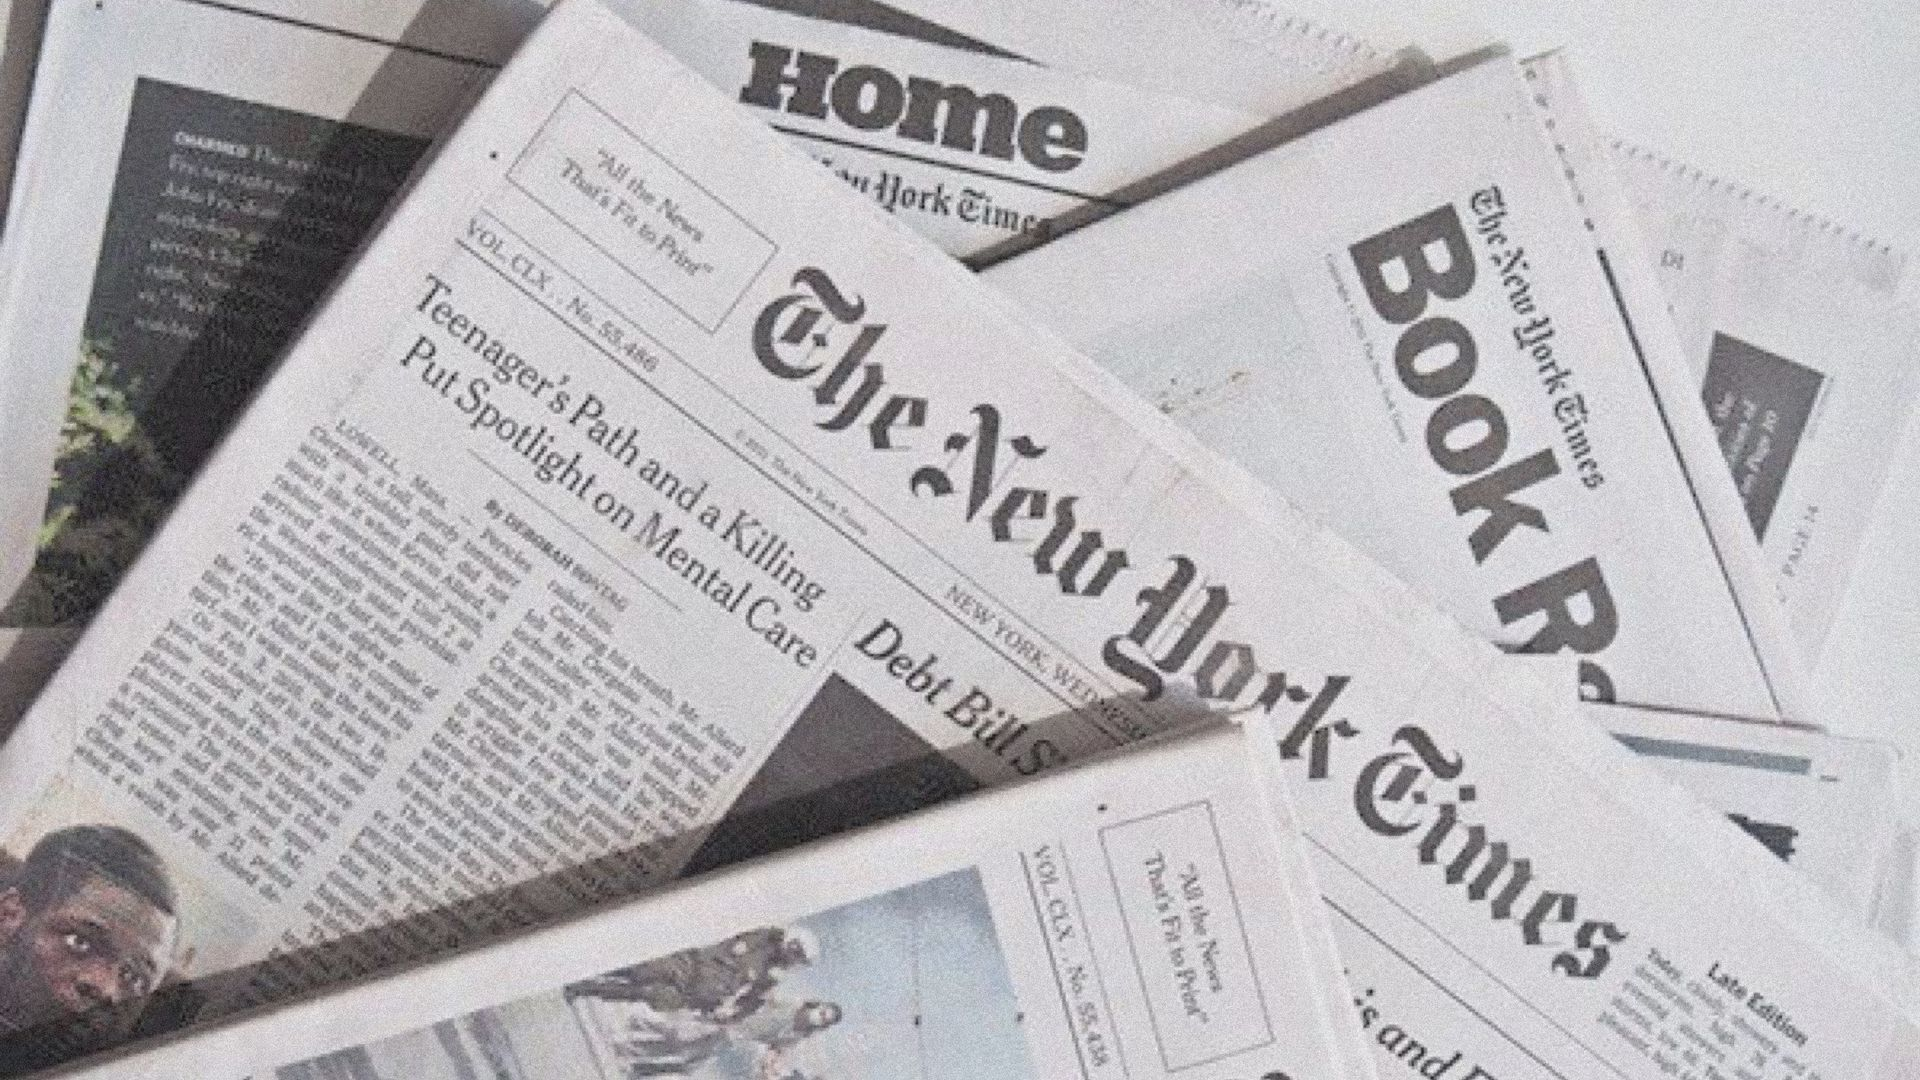

В нынешнюю цифровую эпоху огромный объём информации в интернете усложняет пользователям поиск и отбор релевантного контента.

Новостные сайты включают различные категории, такие как спорт, технологии и развлечения, науку, бизнес и др.

Новостные организации и различные онлайн-платформы сталкиваются с трудной задачей эффективного упорядочивания и классификации огромных объёмов новостных статей, чтобы люди могли получать информацию в соответствии со своими интересами.

Методы обработки естественного языка (NLP) предлагают решение этой проблемы, автоматически классифицируя новостные статьи по заранее определённым темам.

Это похоже на навигацию по библиотеке, где каждая книга аккуратно распределена по категориям на основе заголовка, что экономит ваше время и усилия.

Давайте разберём концепцию NLP и изучим её ключевые компоненты:

* **Токенизация**: это процесс разбиения текста на более мелкие фрагменты, такие как слова или фразы, известные как токены. Эти токены служат базовыми строительными блоками для построения модели NLP.
* **Стемминг и лемматизация**: это методы, используемые для приведения слов к их базовой или корневой форме. Стемминг удаляет префиксы и суффиксы из слов, а лемматизация сопоставляет слова с их каноническими формами на основе словарных определений.
* **POS-тегирование (Part-of-Speech)**: присвоение словам грамматических категорий, таких как существительное, глагол, прилагательное и т. д. Это помогает понять структуру предложений и полезно для анализа текста.
* **Распознавание именованных сущностей (NER)**: процесс идентификации и категоризации именованных сущностей, таких как люди, организации и местоположения, упомянутых в тексте. Это полезно для извлечения структурированной информации из неструктурированных текстовых данных.
* **Анализ тональности**: определение тональности или мнения, которое может быть положительным, отрицательным или нейтральным.

**Процесс построения модели категоризации новостей**

Процесс обычно включает несколько этапов: предобработку данных, извлечение признаков, обучение модели и оценку её эффективности.

# Набор данных для классификации новостей

На первом этапе необходимо собрать набор данных, состоящий из новостных статей разных категорий. Каждая статья должна быть помечена соответствующей категорией.

Для сбора данных и информации можно написать скрипт для осуществления парсинга данных с новостного сайта.
Как пример:"Парсинг новостей с сайта информационного агентства (РИА Новости)" Пример кода осуществления данного паринга будет представлен ниже.

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import datetime
from typing import List, Dict, Any
import json
import re


# Headers для запроса
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 "
                  "Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9,ru;q=0.8,af;q=0.7"
}

# Ключевые слова (взял рандомные слова)
keywords = ["США", "9 мая"]


class HttpResponse:
    def get_response(self, url, params=None, headers=None):
        """
        Выполняем запрос по ссылке
        """
        response = requests.request(
            method="GET",
            url=url,
            params=params,
            headers=headers
        )
        return self.check_response(response)

    def check_response(self, response: requests.Response):
        """
        Проверка статуса запроса
        """
        if response.status_code == 200:
            return response
        else:
            error_message = f"Your request returned {response.status_code} status code."
            if response.status_code == 404:
                error_message += " The requested resource wasn't found."
            elif response.status_code == 500:
                error_message += " The server encountered an internal error."
            raise Exception(error_message)


class NewsParser:
    def __init__(self):
        self.http_response = HttpResponse()

    def get_html_page(self,
                      article_url: str,
                      params: Dict[str, Any] = None,
                      headers: Dict[str, Any] = None
                      ) -> BeautifulSoup:
        """
        Получение HTML кода страницы
        """
        response = self.http_response.get_response(article_url, params, headers)
        soup = BeautifulSoup(response.text, "html.parser")
        return soup

    def get_pages(self, soup: BeautifulSoup) -> List[str]:
        """
        Возвращаем список страниц с новостями
        """
        pages = []
        links = soup.find_all("a", {"class": "list-item__title"})
        for href in links:
            pages.append(href.get("href"))
        return pages

    def extract_info(self, article_url: str) -> Dict[str, Any] | None:
        """
        Извлечение необходимой информации с каждой новости
        """
        soup = self.get_html_page(article_url, headers=HEADERS)
        if soup.find(["div", "h1"], attrs={"class": "article__title"}):
            title = soup.find(["div", "h1"], attrs={"class": "article__title"}).text
        else:
            return None

        summary = ' '.join([i.text for i in soup.findAll("div", class_="article__text")])
        first_sentence_pattern = r"^([^.]\D+[^.]+\.\s)"
        summary = re.sub(first_sentence_pattern, "", summary)

        if any(keyword in title for keyword in keywords) or any(keyword in summary for keyword in keywords):
            authors = soup.find("div", {"class": "endless__item"})["data-author"]
            return {"title": title, "summary": summary, "author": authors}
        else:
            return None

    def return_info(self, url, params, headers):
        """
        Возврат новостей в списке и в JSON файле
        """
        soup = self.get_html_page(article_url=url, params=params, headers=headers)
        pages = self.get_pages(soup)

        # Открытие существующего JSON файла, иначе создание списка data
        try:
            data = self.read_json()
        except FileNotFoundError as e:
            data = []

        # На всякий случай создаем отдельный список, не связанный с data
        result = []

        for page in pages:
            article_info = self.extract_info(page)
            if article_info and article_info not in result and article_info not in data:
                data.append(article_info)
                result.append(article_info)
                self.save_to_json(data)
        return result

    def save_to_json(self, result: List[Dict[str, Any]]):
        """
        Сохранение/обновление JSON файла
        """
        with open("results.json", "w", encoding="utf-8") as outfile:
            json.dump(result, outfile, indent=4, ensure_ascii=False)

    def read_json(self) -> List[Dict[str, Any]]:
        """
        Чтение JSON файла
        """
        with open("results.json", "r", encoding="utf-8") as outfile:
            data = json.load(outfile)
        return data

    def main(self):
        """
        Основной блок программы
        """
        yesterday = datetime.datetime.now() - datetime.timedelta(days=1)

        # +07:00 - часовой пояс Томска
        date_str = yesterday.strftime("%Y-%m-%dT%H:%M:%S+07:00")

        # Основная ссылка
        url = f"https://ria.ru/lenta/"

        # params запроса
        params = {
            "query": "",
            "tags": "",
            "dateFrom": date_str,
            "dateTo": date_str,
            "sort": 'relevance',
        }

        # Бесконечный цикл
        while True:
            now = datetime.datetime.now()
            print(f"Начало парсинга новостей: {now}")
            news = self.return_info(url=url, params=params, headers=HEADERS)
            print(f"Кол-во новостей: {len(news)}")
            for i in news:
                print(i["title"])
            # time.sleep(86400)  # Запуск на сутки
            time.sleep(15)  # Запуск на более короткое время для проверки работы программы
            print()


if __name__ == "__main__":
    ria = NewsParser()
    ria.main()

Но для дальнейшей работы воспользуемся уже собранным источником данных
#### Источник данных: https://www.kaggle.com/amananandrai/ag-news-classification-dataset/notebooks

#### Набор данных для классификации новостей состоит из статей, относящихся к категориям «мир», «спорт», «бизнес» и «наука».

## **1. Цель**

По заголовку и описанию нужно определить, к какой категории новостной статьи они относятся.

### 1.1 Тип задачи машинного обучения:
Нужно предсказать категорию новостной статьи на основе предоставленной информации, поэтому это задача многоклассовой классификации.

### 1.2 Как определить, к какой категории новостной статьи относится текст?
Мы можем использовать методы обработки естественного языка, чтобы преобразовать заданные тексты в векторы, поскольку машины понимают числа. Для этого можно применить некоторые методы предварительной обработки данных, такие как Word2Vec, Bag of Words, TF-IDF и т. д., а затем использовать алгоритм машинного обучения для классификации.

## 2. Загрузка данных.

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('train.csv')
train.shape

(120000, 3)

In [3]:
test = pd.read_csv('test.csv')
test.shape

(7600, 3)

### 2.1 Объединение обучающего(train) и тестового(test) наборов данных в единый датафрейм для предварительной обработки текста.

In [4]:
frames = [train,test]
df = pd.concat(frames)

In [5]:
df.shape

(127600, 3)

In [6]:
df.head(3)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...


In [7]:
print('total shape',df.shape)
print('total columns',df.columns)
print('*'*50)
print(df.info())

total shape (127600, 3)
total columns Index(['Class Index', 'Title', 'Description'], dtype='object')
**************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 127600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  127600 non-null  int64 
 1   Title        127600 non-null  object
 2   Description  127600 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.9+ MB
None


### 2.2 Информация об атрибутах:
1: Индекс класса: метки присвоены соответствующим категориям новостных статей, например, спорт: 1, наука: 2 и так далее.

2: Заголовок: заголовок новости.

3: Описание: новость, относящаяся к указанным статьям.

## 3. Разведочный анализ данных

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [9]:
df['Class Index'].value_counts()   # Сбалансированный набор данных

,count
Class Index,
3,31900
4,31900
2,31900
1,31900


### 3.1  Давайте проверим, к какой категории относится каждая новостная статья, используя группировку.

In [10]:
g = df.groupby(['Class Index'])
s = g.get_group(2)
s.head(3)    # 2 : Спорт

<ipython-input-10-323c732d7730>:2: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  s = g.get_group(2)


,Class Index,Title,Description
448,2,"Phelps, Thorpe Advance in 200 Freestyle (AP)",AP - Michael Phelps took care of qualifying fo...
449,2,Reds Knock Padres Out of Wild-Card Lead (AP),AP - Wily Mo Pena homered twice and drove in f...
450,2,"Dreaming done, NBA stars awaken to harsh Olymp...",AFP - National Basketball Association players ...


In [11]:
b = g.get_group(3)
b.head(3)     # 3: Бизнес

<ipython-input-11-fc2d1a136e42>:1: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  b = g.get_group(3)


,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...


In [12]:
sc = g.get_group(4)
sc.head(3)    # 4: Наука

<ipython-input-12-9029cefa12cb>:1: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sc = g.get_group(4)


,Class Index,Title,Description
78,4,"'Madden,' 'ESPN' Football Score in Different W...",Reuters - Was absenteeism a little high\on Tue...
79,4,Group to Propose New High-Speed Wireless Forma...,Reuters - A group of technology companies\incl...
80,4,AOL to Sell Cheap PCs to Minorities and Senior...,Reuters - America Online on Thursday said it\p...


In [13]:
w = g.get_group(1)
w.head(3)    # 1: Новости мира

<ipython-input-13-5b1e238fc776>:1: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  w = g.get_group(1)


,Class Index,Title,Description
492,1,Venezuelans Vote Early in Referendum on Chavez...,Reuters - Venezuelans turned out early\and in ...
493,1,S.Koreans Clash with Police on Iraq Troop Disp...,Reuters - South Korean police used water canno...
494,1,Palestinians in Israeli Jails Start Hunger Str...,Reuters - Thousands of Palestinian\prisoners i...


### 3.2 Давайте присвоим метки каждому индексу класса и создадим ещё один столбец с помощью словаря.

In [14]:
labels = {1:'World',2:'Sports',3:'Buisness',4:'Science & Tech'}
df['labels'] = df['Class Index'].map(labels)

In [15]:
df.head()

,Class Index,Title,Description,labels
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Buisness
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Buisness
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Buisness
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Buisness
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",Buisness


### 3.3 Теперь объединим столбцы «Title» и «Description» в один столбец ['Summary'].

In [16]:
df['Summary'] = df['Title'] + ' ' + df['Description']
df.drop(columns=['Title', 'Description'],inplace=True)

In [17]:
df.head(3)

,Class Index,labels,Summary
0,3,Buisness,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Buisness,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Buisness,Oil and Economy Cloud Stocks' Outlook (Reuters...


In [18]:
df.labels.value_counts()

,count
labels,
Buisness,31900
Science & Tech,31900
Sports,31900
World,31900


### 3.4 Распределение точек данных по новостным лентам

<Axes: xlabel='labels'>

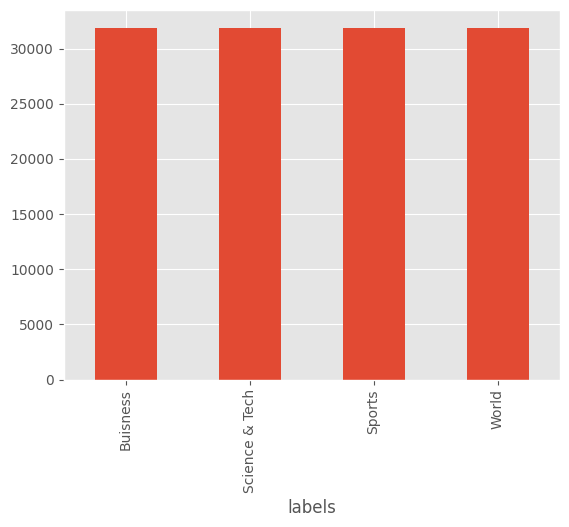

In [19]:
df.labels.value_counts().plot(kind = 'bar')     # Сбалансированный набор данных

На представленном графике показано распределение количества новостей по категориям (World, Science & Tech, Sports, Business):

Выводы:

1. Примерно равное распределение  
   Все четыре класса имеют схожее количество объектов (около 9000–9800 в каждом классе). Это говорит о том, что набор данных сбалансирован.

2. Небольшие различия  
   Категории Science & Tech и World имеют чуть больше примеров, чем Sports и Business, но разница незначительная.

3. Преимущество для обучения моделей  
   Сбалансированное распределение классов важно для обучения моделей классификации, так как снижает риск переобучения на чаще встречающиеся категории и обеспечивает справедливое представление всех тем.

Общий вывод:  
Датасет сбалансирован по всем основным категориям, что положительно скажется на качестве и объективности моделей машинного обучения, которые мы будем в дальнейшей работе тренировать на этих данных.

#### Что мы сделали на данный момент ?
1:Объединили тренировочный и тестовый наборы данных в один.

2:Создали новый столбец = labels

3:Объединили «заголовок» и «описание» в один столбец = summary

### 3.5 Проверим наличие пустых значений (null):

In [20]:
df.isnull().sum()

,0
Class Index,0
labels,0
Summary,0


#### Экспорт файла в формат CSV

In [21]:
df.to_csv('df.csv',index = 'False')

## 4. EDA: предварительная обработка текста

**Предобработка данных**
* После сбора данных следующий шаг — очистка и нормализация текстовых данных. Она включает в себя удаление тегов, пунктуации, специальных символов и стоп-слов.
Также текст часто приводится к нижнему регистру, а методы лемматизации и стемминга применяются для приведения слов к их корневым формам.

In [22]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer    # lemmatize
from wordcloud import WordCloud, STOPWORDS
import string

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [25]:
df1 = pd.read_csv('train.csv')

df1.head(5)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [26]:
df2 = pd.read_csv('test.csv')

df2.head(2)

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."


In [27]:
frames = [df1,df2]
df = pd.concat(frames)

In [28]:
df.shape

(127600, 3)

### 4.1 Создание облаков слов
Создание облаков слов для новостных статей категорий «мир», «спорт», «бизнес» и «наука»
Мы можем увидеть наиболее часто встречающиеся слова

In [29]:
STOP_WORDS = stopwords.words('english')

In [30]:
stopwords = set(STOP_WORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.remove("not")
stopwords.remove("no")
stopwords.add(" ")

##### Мир

In [31]:
world = df.Description[df['Class Index'][df['Class Index']==1].index]

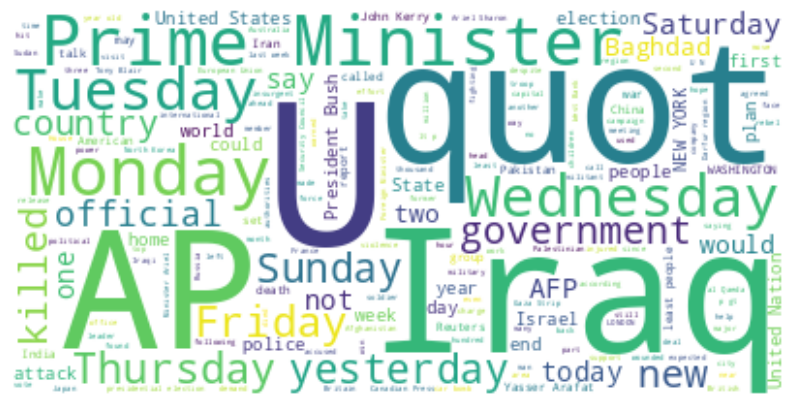

In [32]:
plt.figure(figsize = (10,15))
wc = WordCloud(max_words=500,background_color='White',stopwords=stopwords)
wc.generate(" ".join(world))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Данный график представляет собой облако слов (wordcloud), которое визуализирует наиболее часто встречающиеся слова в анализируемых текстах (новостных статьях).

Выводы:

1. Наиболее частые слова  
   Самыми крупными и, соответственно, наиболее часто встречающимися словами являются:  
   - quot  
   - Iraq  
   - AP  
   - Prime Minister  
   - killed  
   - government  
   - Monday, Tuesday, Wednesday и другие дни недели  

2. Тематика текстов  
   - Часто встречающиеся слова вроде *Iraq*, *Prime Minister*, *government*, *killed* указывают на то, что в новостных текстах много упоминаний политики, международных отношений и, возможно, военных конфликтов.
   - Присутствие дней недели (Monday, Tuesday и др.), а также слов *yesterday*, *today*, *year* говорит о том, что новости привязаны ко времени событий и часто содержат ссылки на даты.

3. Источники информации  
   - Слова *AP* (Associated Press), *AFP* и *Reuters* – наименования крупных мировых информационных агентств, встречаются часто, что говорит о цитировании официальных источников.
   
4. Особенности текста  
   - Очень часто встречается слово quot— это не слово из английского языка, а результат некорректного парсинга текста ("quot;" — HTML-код для кавычек). Это может указывать на необходимость более качественной обработки данных для удаления или исправления подобных артефактов.

Общий вывод:

Облако слов показывает, что тексты в датасете преимущественно посвящены событиям в Ираке, политическим новостям и международным отношениям, часто содержат ссылки на временные метки и официальные источники. Присутствие технических артефактов (например, "quot") может ухудшать качество анализа и требует дополнительного препроцессинга текста.

##### Спорт

In [33]:
sports = df.Description[df['Class Index'][df['Class Index']==2].index]

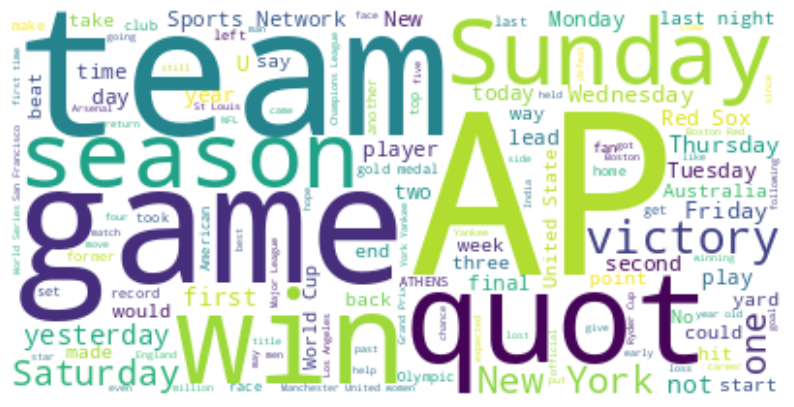

In [34]:
plt.figure(figsize = (10,15))
wc = WordCloud(max_words=500,background_color='White',stopwords=stopwords)
wc.generate(" ".join(sports))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

1. Тематика текстов
- Наиболее крупные и заметные слова: team, game, season, win, race, victory, play.
- Это слова, характерные для спортивной тематики, что говорит о том, что анализируемый корпус текстов посвящён спортивным событиям.

2. Привязка ко времени
- Очень часто встречаются дни недели (Sunday, Monday, Tuesday, Wednesday, Thursday, Friday, Saturday), а также слова yesterday, today — это типично для спортивных новостей, где часто указывают дату или день проведения матчей и событий.

3. Географические и организационные упоминания
- Встречаются наименования команд, мест и соревнований: New York, Red Sox, World Cup, Athens, Australia, Manchester United и др., что подтверждает привязку к спортивным событиям мирового масштаба.

4. Источники информации
- Крупно выделено слово AP (Associated Press), что указывает на частые ссылки на информационные агентства.

5. Наличие технических артефактов
- Такое же слово как quot (может быть результатом неправильной обработки HTML-кодов кавычек), что говорит о необходимости дополнительной фильтрации текста.

##### Бизнес

In [35]:
Buisness = df.Description[df['Class Index'][df['Class Index']==3].index]

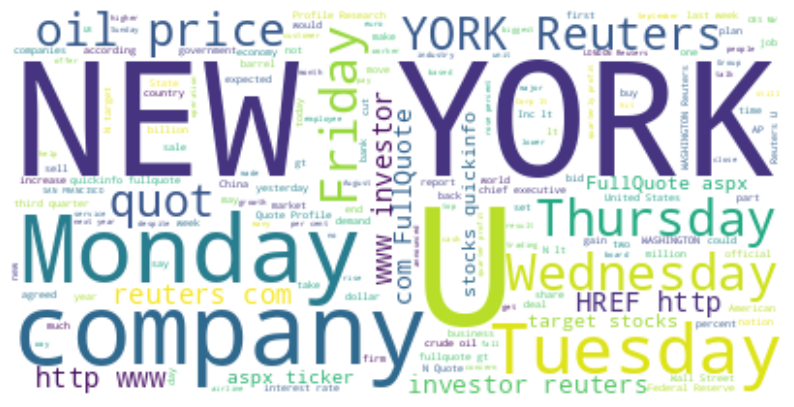

In [36]:
plt.figure(figsize = (10,15))
wc = WordCloud(max_words=500,background_color='White',stopwords=stopwords)
wc.generate(" ".join(Buisness))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

1. Тематика текстов
- Самые крупные слова: NEW YORK, company, Monday, YORK, investor, oil, price, Reuters.
- Данные слова указывают на то, что тексты, скорее всего, связаны с бизнесом и экономикой. Здесь часто упоминаются компании, инвесторы, цены (например, на нефть), экономические показатели.

2. Географическая привязка
- Слово NEW YORK крайне заметно, что логично для бизнес-новостей, так как Нью-Йорк — мировой финансовый центр (биржи, корпорации и т.д.).

3. Временная привязка
- Часто встречающиеся дни недели (Monday, Tuesday, Wednesday, Thursday, Friday) типичны для финансовых и деловых новостей, отражающих будние рабочие дни рынков.

4. Источники информации и технические термины
- Много слов, относящихся к информационным агентствам (Reuters), а также технические термины веб-формата (http, www, com, HREF, FullQuote). Это может говорить о наличии ссылок или автоматических заголовков, которые не были полностью очищены при подготовке данных.

5. Часто встречающиеся слова
- oil, price, stocks, investor, target, Wall Street — абсолютно профильные для бизнес-новостей.

6. Неочищенные данные
- Есть технические слова и артефакты (“http”, “www”, “HREF”), что свидетельствует о необходимости дополнительной очистки текстов от информации, не относящейся к смыслу новостей.

##### Наука

In [37]:
Sci_Tech = df.Description[df['Class Index'][df['Class Index']==4].index]

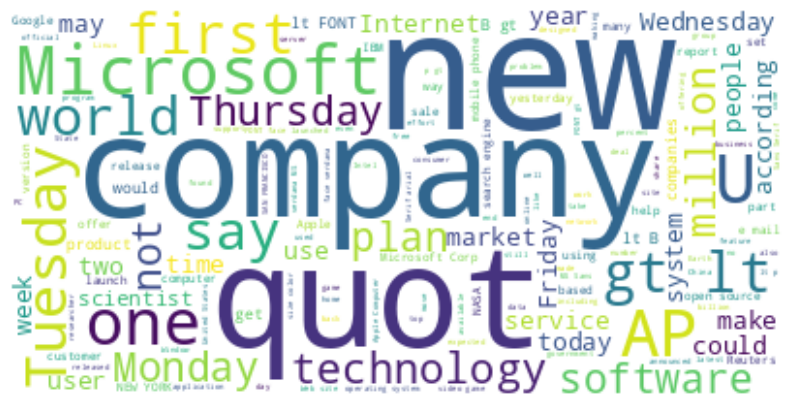

In [38]:
plt.figure(figsize = (10,15))
wc = WordCloud(max_words=500,background_color='White',stopwords=stopwords)
wc.generate(" ".join(Sci_Tech))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

1. Тематика текстов
- Самые заметные слова: company, new, Microsoft, technology, software, product, service, user.
- Явное преобладание терминов, связанных с технологиями, софтвером и компаниями, говорит о том, что перед нами тексты, посвящённые науке и технологиям, IT-бизнесу и инновациям.

2. Географическая и корпоративная специфика
- Часто встречается слово Microsoft, упоминаются другие крупные технологические компании (Google, IBM, Apple и т.д., хотя они мельче).
- Слово world указывает на глобальный охват событий.

3. Временная привязка
- Замечены дни недели: Tuesday, Thursday, Monday, Friday, Wednesday — типично для новостных публикаций и анонсов продукции.

4. Особенности источников
- Присутствие слова AP (Associated Press) — частые ссылки на агентство новостей, приводящее официальную информацию по событиям.

5. Технические артефакты
- Очень крупное слово quot и встречающиеся gt, lt, FONT — это остатки html-разметки и технических символов, которые желательно удалить для чистоты анализа.

6. Часто употребляемые ключевые слова
- Много специфических терминов: software, technology, product, service, launch, open source, market, scientist, report, Internet, user — всё это профильные слова для ИТ и технологических новостей.

В данной категории новостные тексты преимущественно посвящены компаниям ИТ-сектора, технологическим инновациям, новым продуктам и разработкам, с активным упоминанием Microsoft и других мировых брендов. Присутствие html-артефактов говорит о необходимости дополнительной очистки данных для более эффективного анализа.

In [39]:
df['Summary'] = df['Title'] + ' ' + df['Description']
df.drop(columns=['Title', 'Description'],inplace=True)

In [40]:
df.head()

,Class Index,Summary
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


## 4.2 Предварительная обработка текста
Предварительная обработка включает:
* удаление HTML-тегов;
* удаление пунктуации;
* стемминг (приведение слов к корню);
* удаление стоп-слов;
* раскрытие сокращений и т. д.

### 4.2.1 Раскрытие сокращений

In [41]:
def text_preproces(x):
    x = str(x).lower()
    x = x.replace('%',' percent').replace('₹',' rupee').replace('$',' dollar').replace('€',' euro')\
                                .replace(',000,000','m').replace('000','k').replace('′',"'").replace("’","'")\
                                .replace("won't","will not").replace("can't",'can not').replace("shouldn't","should not")\
                                .replace("what's",'"what is"').replace("that's",'that is').replace("he's","he is")\
                                .replace("she's","she is").replace("it's","it is").replace("'ve"," have").replace("'re"," are")\
                                .replace("'ll"," will").replace("i'm","i am").replace("n't", " not")
    x = re.sub(r'([0-9]+)000000',r'\1m',x)
    x = re.sub(r'([0-9]+)000',r'\1k',x)

    return x

In [42]:
def extract_features(df):
    df['Summary'] = df['Summary'].fillna("").apply(text_preproces)
    print("token features...")

    return df

In [43]:
df = extract_features(df)

token features...


In [44]:
df.head()

,Class Index,Summary
0,3,wall st. bears claw back into the black (reute...
1,3,carlyle looks toward commercial aerospace (reu...
2,3,oil and economy cloud stocks' outlook (reuters...
3,3,iraq halts oil exports from main southern pipe...
4,3,"oil prices soar to all-time record, posing new..."


### 4.2.2 Удаление URL-адресов

In [45]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

df.Summary=df.Summary.apply(remove_urls)

### 4.2.3 Удаление HTML-тегов

In [46]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

df.Summary=df.Summary.apply(remove_html)

### 4.2.4  Токенизация данных — findall()

Функция re.findall() является одной из самых полезных и часто используемых функций модуля re в Python. Она позволяет находить все совпадения с заданным регулярным выражением в строке и возвращать их в виде списка. Это особенно полезно, когда нужно извлечь несколько элементов, соответствующих определенному шаблону. Регулярные выражения могут показаться сложными на первый взгляд, но с помощью re.findall() их использование становится гораздо проще и интуитивно понятнее.

Синтаксис функции re.findall() выглядит следующим образом:

re.findall(pattern, string, flags=0)

pattern: регулярное выражение, которое вы хотите использовать для поиска.
string: строка, в которой будет производиться поиск.
flags: дополнительные флаги, которые могут изменить поведение поиска (по умолчанию равно 0).

Пример: Поиск всех email-адресов в тексте

import re

text = "Контакты: john.doe@example.com, jane_doe123@domain.net"
pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'

matches = re.findall(pattern, text)
print(matches)  # Вывод: ['john.doe@example.com', 'jane_doe123@domain.net']

Регулярное выражение [a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,} используется для поиска email-адресов. Оно учитывает различные символы, которые могут быть частью email-адреса, включая буквы, цифры и специальные символы.

In [47]:
def word_tokenize(txt):
    tokens = re.findall("[\w']+", txt)
    return tokens
df.Summary=df.Summary.apply(word_tokenize)

### 4.2.5 Удаление стоп-слов (stopwords)

In [48]:
def remove_stopwords(lst):
    stop=stopwords
    new_lst=[]
    for i in lst:
        if i not in stop:
            new_lst.append(i)
    return new_lst

df.Summary=df.Summary.apply(remove_stopwords)

In [49]:
def remove_extrawords(lst):
    stop=['href','lt','gt','ii','iii','ie','quot','com']   ## Эти слова встречаются наиболее часто, как мы заметили в облаке слов, и они не несут смысловой нагрузки.
    new_lst=[]
    for i in lst:
        if i not in stop:
            new_lst.append(i)
    return new_lst

df.Summary=df.Summary.apply(remove_extrawords)

### 4.2.6 Удаление пунктуационных символов

In [50]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [51]:
def remove_punctuations(lst):
    new_lst=[]
    for i in lst:
        for j in  string.punctuation:
            i=i.replace(j,'')
        new_lst.append(i)
    return new_lst
df.Summary=df.Summary.apply(remove_punctuations)

### 4.2.7 Удаление цифр (чисел)

In [52]:
def remove_numbers(lst):
    nodig_lst=[]
    new_lst=[]

    for i in  lst:
        for j in  string.digits:
            i=i.replace(j,'')
        nodig_lst.append(i)
    for i in  nodig_lst:
        if  i!='':
            new_lst.append(i)
    return new_lst
df.Summary=df.Summary.apply(remove_numbers)

### 4.2.8 Лемматизация данных

Лемматизация в Python — это алгоритмический процесс нахождения леммы слова в зависимости от его значения и контекста.  

Он относится к морфологическому анализу слов, направленному на удаление флективных окончаний и на возвращение начальной формы слова, то есть леммы.

In [53]:
lemmatizer = WordNetLemmatizer()

In [54]:
def lemmatzation(lst):
    new_lst=[]
    for i in lst:
        i=lemmatizer.lemmatize(i)
        new_lst.append(i)
    return new_lst
df.Summary=df.Summary.apply(lemmatzation)

In [55]:
df.isnull().sum()

,0
Class Index,0
Summary,0


#### Экспорт файла в формат CSV

In [56]:
df.to_csv('df.csv',index = 'False')

## 5. Разделение данных на обучающую, тестовую и валидационную выборки

**Извлечение признаков**
* Из текстовых данных извлекаются признаки, чтобы представить их в определённом формате, понятном для моделей машинного обучения.
Некоторые распространённые методы извлечения признаков: Bag-of-Words (BoW), Term Frequency-Inverse Document Frequency (TF-IDF), Word Embeddings.

In [59]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer    # Лемматизация
from wordcloud import WordCloud, STOPWORDS
import string
from sklearn.feature_extraction.text import CountVectorizer #Bag-of-Words (мешок слов)
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF (Term Frequency-Inverse Document Frequency)

In [60]:
!pip install distance
import distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16256 sha256=0e94e2a5be04241d82d23cd3578e50f6bd4b8aab0eaa7888abdf29834ca205df
  Stored in directory: /root/.cache/pip/wheels/fb/cd/9c/3ab5d666e3bcacc58900b10959edd3816cc9557c7337986322
Successfully built distance


In [61]:
import pandas as pd

In [62]:
df = pd.read_csv('df.csv')
df.head()

,Unnamed: 0,Class Index,Summary
0,0,3,"['wall', 'st', 'bear', 'claw', 'back', 'black'..."
1,1,3,"['carlyle', 'look', 'toward', 'commercial', 'a..."
2,2,3,"['oil', 'economy', 'cloud', 'stock', 'outlook'..."
3,3,3,"['iraq', 'halt', 'oil', 'export', 'main', 'sou..."
4,4,3,"['oil', 'price', 'soar', 'time', 'record', 'po..."


In [63]:
df = df.drop(['Unnamed: 0'],axis = 'columns')

In [64]:
df.shape

(127600, 2)

In [ ]:
df.head(2)

,Class Index,Summary
0,3,"['wall', 'st', 'bear', 'claw', 'back', 'black'..."
1,3,"['carlyle', 'look', 'toward', 'commercial', 'a..."


In [65]:
from sklearn.model_selection import train_test_split

In [66]:
X_train, X_test  = train_test_split(df,test_size=0.2,stratify = df['Class Index'])
X_train, X_val = train_test_split(X_train,test_size=0.20,stratify = X_train['Class Index'])

Что делает параметр stratify=True в функции разделения данных на обучающую и тестовую выборки?

Он обеспечивает корректную выборку данных, благодаря чему в каждой из подмножеств (обучающей и тестовой выборках) будет одинаковое количество значений каждого класса.
Мы можем проверить это с помощью y_train.value_counts(), чтобы убедиться в равномерном распределении меток в нашей выборке.

In [67]:
X_train.shape

(81664, 2)

In [68]:
X_test.shape

(25520, 2)

In [69]:
X_val.shape

(20416, 2)

In [70]:
X_train['Class Index'].value_counts()

,count
Class Index,
3,20416
2,20416
1,20416
4,20416


In [71]:
X_test['Class Index'].value_counts()

,count
Class Index,
3,6380
2,6380
1,6380
4,6380


In [72]:
X_val['Class Index'].value_counts()

,count
Class Index,
3,5104
4,5104
1,5104
2,5104


## 6 Создание моделей

1. TF-IDF
2. Униграммы, биграммы, n-граммы
3. Выбор максимального количества признаков для модели


### 6.1 TF-IDF

Term Frequency-Inverse Document Frequency (TF-IDF) — это один из наиболее распространенных и мощных методов для извлечения признаков из текстовых данных.
TF-IDF помогает выделить ключевые слова и фразы, которые наиболее важны для конкретного документа, что делает его незаменимым инструментом для таких задач, как ранжирование документов в поисковых системах, автоматическая аннотация текстов и тематическая классификация. Важно понимать, что TF-IDF не только учитывает частоту появления слова в документе, но и его распространенность в других документах, что позволяет более точно оценить его значимость.

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [74]:
vectorizer_tf = TfidfVectorizer(tokenizer=None,stop_words=None,max_df=0.75,max_features=2000,lowercase=False,ngram_range=(1,2))
train_vectors = vectorizer_tf.fit_transform(X_train.Summary)   # для train

In [75]:
test_vectors = vectorizer_tf.transform(X_test.Summary)   # для test

In [76]:
val_vectors = vectorizer_tf.transform(X_val.Summary)    # для валидации

In [77]:
print('Shape of X_train:',X_train.shape)
print('Shape of X_test:',X_test.shape)
print('Shape of X_val:',X_val.shape)
print('Shape of train_vectors:',train_vectors.shape)
print('Shape of test_vectors:',test_vectors.shape)
print('Shape of val_vectors:',val_vectors.shape)

Shape of X_train: (81664, 2)
Shape of X_test: (25520, 2)
Shape of X_val: (20416, 2)
Shape of train_vectors: (81664, 2000)
Shape of test_vectors: (25520, 2000)
Shape of val_vectors: (20416, 2000)


##### Что такое max_df = 0.75?
Параметр max_df используется для удаления значений данных, которые встречаются слишком часто, также известных как «стоп-слова для конкретного корпуса». Например, max_df = 0.50 означает «игнорируются термины, которые встречаются более чем в 50 % документов». max_df = 25 означает «игнорируются термины, которые встречаются более чем в 25 документах».

##### Небольшой пример n-грамма

In [78]:
vectorizer_tf.get_feature_names_out()

array(['able', 'abu', 'abuse', ..., 'zealand', 'zimbabwe', 'zone'],
      dtype=object)

In [79]:
vectorizer_tf.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': False,
 'max_df': 0.75,
 'max_features': 2000,
 'min_df': 1,
 'ngram_range': (1, 2),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [80]:
df.head()

,Class Index,Summary
0,3,"['wall', 'st', 'bear', 'claw', 'back', 'black'..."
1,3,"['carlyle', 'look', 'toward', 'commercial', 'a..."
2,3,"['oil', 'economy', 'cloud', 'stock', 'outlook'..."
3,3,"['iraq', 'halt', 'oil', 'export', 'main', 'sou..."
4,3,"['oil', 'price', 'soar', 'time', 'record', 'po..."


In [81]:
train_df = pd.DataFrame(train_vectors.toarray(),columns=vectorizer_tf.get_feature_names_out())
train_df = pd.concat([train_df,X_train['Class Index'].reset_index(drop = True)],axis = 1)

train_df

,able,abu,abuse,access,according,account,accounting,accused,acquire,acquisition,...,yet,york,york reuters,york yankee,young,yukos,zealand,zimbabwe,zone,Class Index
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81659,0.0,0.0,0.0,0.0,0.311817,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
81660,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
81661,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
81662,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [82]:
test_df = pd.DataFrame(test_vectors.toarray(),columns=vectorizer_tf.get_feature_names_out())
test_df = pd.concat([test_df,X_test['Class Index'].reset_index(drop = True)],axis = 1)

test_df

,able,abu,abuse,access,according,account,accounting,accused,acquire,acquisition,...,yet,york,york reuters,york yankee,young,yukos,zealand,zimbabwe,zone,Class Index
0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3
2,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25515,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.156622,0.0,0.257235,0.0,0.0,0.0,0.0,0.0,2
25516,0.0,0.0,0.0,0.0,0.16981,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,4
25517,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2
25518,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2


In [83]:
val_df = pd.DataFrame(val_vectors.toarray(),columns=vectorizer_tf.get_feature_names_out())
val_df = pd.concat([val_df,X_val['Class Index'].reset_index(drop = True)],axis = 1)

val_df

,able,abu,abuse,access,according,account,accounting,accused,acquire,acquisition,...,yet,york,york reuters,york yankee,young,yukos,zealand,zimbabwe,zone,Class Index
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.121797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
20412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
20413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
20414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


#### Экспорт файла в формат CSV

In [84]:
train_df.to_csv('train_df.csv',index ='False')

In [85]:
test_df.to_csv('test_df.csv',index ='False')

In [87]:
val_df.to_csv('val_df.csv',index ='False')

In [86]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [88]:
train_df = pd.read_csv('train_df.csv')

In [89]:
train_df = train_df.drop(['Unnamed: 0'],axis = 'columns')

In [90]:
train_df.head(3)

,able,abu,abuse,access,according,account,accounting,accused,acquire,acquisition,...,yet,york,york reuters,york yankee,young,yukos,zealand,zimbabwe,zone,Class Index
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [91]:
X_train = train_df.drop(['Class Index'],axis = 'columns')

In [92]:
y_train = train_df['Class Index']

In [93]:
y_train.shape

(81664,)

In [94]:
X_train.shape

(81664, 2000)

In [95]:
test_df = pd.read_csv('test_df.csv')

In [96]:
test_df = test_df.drop(['Unnamed: 0'],axis = 'columns')

In [97]:
test_df.head(3)

,able,abu,abuse,access,according,account,accounting,accused,acquire,acquisition,...,yet,york,york reuters,york yankee,young,yukos,zealand,zimbabwe,zone,Class Index
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [98]:
X_test = test_df.drop(['Class Index'],axis = 'columns')

In [99]:
y_test = test_df['Class Index']

In [100]:
X_test.shape

(25520, 2000)

In [101]:
val_df = pd.read_csv('val_df.csv')

In [102]:
val_df = val_df.drop(['Unnamed: 0'],axis = 'columns')

In [103]:
val_df.head(3)

,able,abu,abuse,access,according,account,accounting,accused,acquire,acquisition,...,yet,york,york reuters,york yankee,young,yukos,zealand,zimbabwe,zone,Class Index
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [104]:
X_val = val_df.drop(['Class Index'],axis = 'columns')

In [105]:
y_val = val_df['Class Index']

In [106]:
X_val.shape

(20416, 2000)

In [107]:
y_val.shape

(20416,)

## 7. Применение моделей машинного обучения

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [109]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#sklearn.linear_model.LogisticRegression
lr_model = LogisticRegression(penalty='l2',solver= 'newton-cg',multi_class= 'multinomial')
# L2-регуляризация помогает преодолеть проблему переобучения и недообучения.
# solver = newton-cg... Для задач с несколькими классами только «newton-cg», «sag», «saga» и «lbfgs» поддерживают многономиальную функцию потерь; «liblinear» ограничен схемами «один против всех».
lr_model.fit(X_train,y_train)
pred = lr_model.predict(X_val)

In [110]:
print("first 20 actual labels")
print(y_val.tolist()[:20])
print("first 20 predicted labels")
print(pred.tolist()[:20])

first 20 actual labels
[3, 4, 4, 1, 3, 4, 4, 3, 1, 3, 2, 4, 3, 4, 4, 3, 1, 2, 2, 1]
first 20 predicted labels
[3, 4, 4, 1, 3, 4, 4, 4, 1, 3, 2, 4, 3, 1, 4, 3, 1, 2, 2, 1]


### Матрица ошибок (Confusion Matrix)

In [111]:
def confusion_mat(color):
    cof=confusion_matrix(y_val, pred)
    cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
    sns.set(font_scale=1.5)
    plt.figure(figsize=(8,8));

    sns.heatmap(cof, cmap=color,linewidths=1, annot=True,square=True, fmt='d', cbar=False,xticklabels=['World','Sports','Business','Science'],yticklabels=['World','Sports','Business','Science']);
    plt.xlabel("Predicted Classes");
    plt.ylabel("Actual Classes");

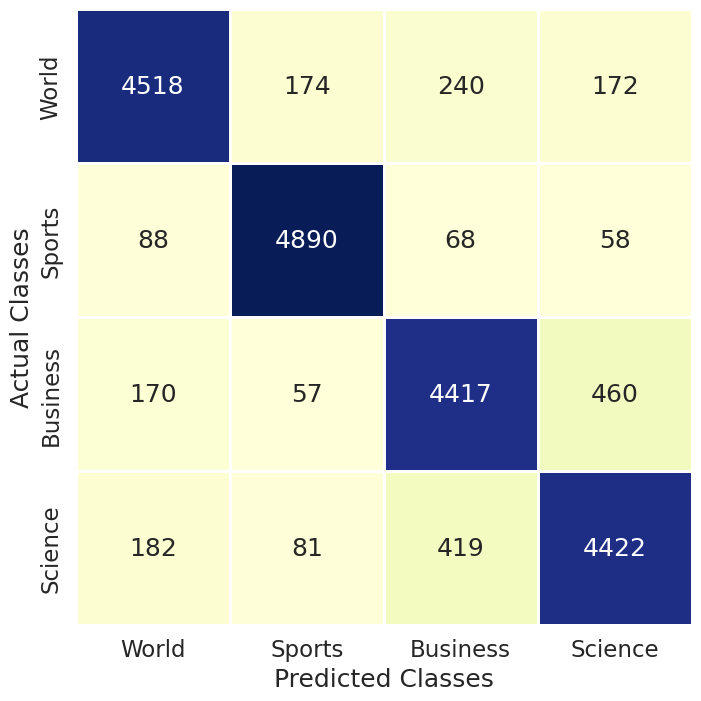

In [112]:
confusion_mat('YlGnBu')

### Точность (Precision), полнота (Recall), F1-мера (F1-Score)

**Оценка модели**
* После обучения модель необходимо оценить, чтобы определить её эффективность. Это обычно делается с использованием таких метрик, как точность (accuracy), прецизионность (precision), полнота (recall) и F1-мера.

In [113]:
print('\nClassification Report\n')
print(classification_report(y_val,pred))


Classification Report

              precision    recall  f1-score   support

           1       0.91      0.89      0.90      5104
           2       0.94      0.96      0.95      5104
           3       0.86      0.87      0.86      5104
           4       0.87      0.87      0.87      5104

    accuracy                           0.89     20416
   macro avg       0.89      0.89      0.89     20416
weighted avg       0.89      0.89      0.89     20416



Pr = True Positive / (True Positive + False Positive) — точность.

Recall = True Positive Rate = True Positive / Positive — полнота (доля правильно предсказанных положительных случаев среди всех положительных).

F1 = 2 * [Pr * Re / (Pr + Re)] — F1-мера (гармоническое среднее между точностью и полнотой).

Примечание:
- Точность — это доля правильно предсказанных положительных результатов среди всех предсказанных положительных.
- Полнота — это доля правильно предсказанных положительных результатов среди всех фактических положительных.

Также есть метрики Accuracy (правильность) и Error (ошибка).

In [114]:
a1 = round(accuracy_score(y_val,pred)*100,4)
a2 = round(100-accuracy_score(y_val,pred)*100,4)
print('Accuracy:',a1)
print('Error:',a2)


Accuracy: 89.376
Error: 10.624


Точность (Accuracy) = [Количество правильно классифицированных точек / Общее количество точек в Dtest].

Ошибка (Error) = 1 − Точность.

Стохастический градиентный спуск (Stochastic Gradient Descent).

In [115]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
from sklearn.linear_model import SGDClassifier

In [116]:
sgd_model = SGDClassifier(early_stopping=True,penalty='l2',alpha=0.00001)
sgd_model.fit(X_train,y_train)
pred_sgd = sgd_model.predict(X_val)

In [117]:
print("first 20 actual labels")
print(y_val.tolist()[:20])
print("first 20 predicted labels")
print(pred_sgd.tolist()[:20])

first 20 actual labels
[3, 4, 4, 1, 3, 4, 4, 3, 1, 3, 2, 4, 3, 4, 4, 3, 1, 2, 2, 1]
first 20 predicted labels
[3, 4, 4, 1, 3, 4, 4, 4, 1, 3, 2, 4, 3, 1, 4, 3, 1, 2, 2, 1]


#### Матрица ошибок (Confusion matrix).

In [118]:
def confusion_mat(color):
    cof=confusion_matrix(y_val, pred_sgd)
    cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
    sns.set(font_scale=1.5)
    plt.figure(figsize=(8,8));

    sns.heatmap(cof, cmap=color,linewidths=1, annot=True,square=True, fmt='d', cbar=False,xticklabels=['World','Sports','Business','Science'],yticklabels=['World','Sports','Business','Science']);
    plt.xlabel("Predicted Classes");
    plt.ylabel("Actual Classes");

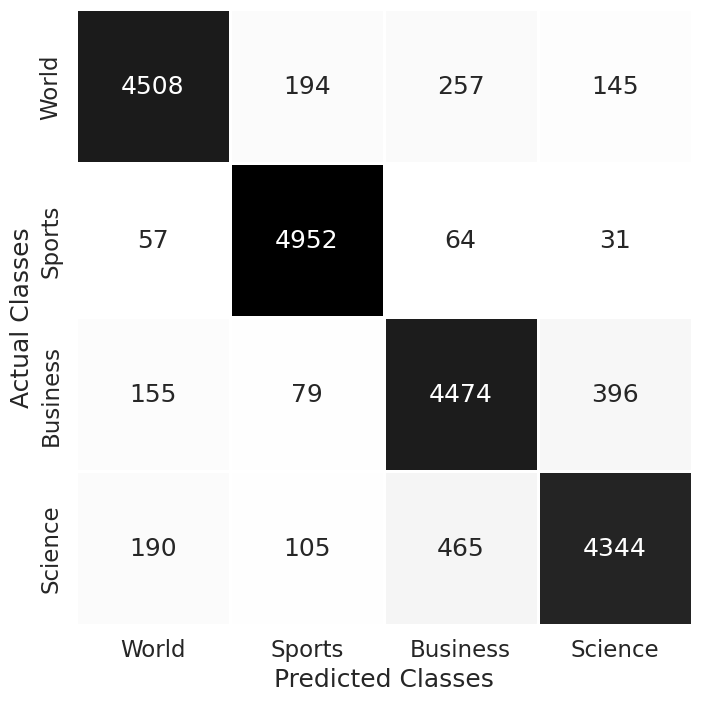

In [119]:
confusion_mat('Greys')

**Качество классификации по классам**

*Класс World (Мир)*
- Верно классифицировано: 4508
- Ошибочно как Sports: 194
- Ошибочно как Business: 257
- Ошибочно как Science: 145

Вывод:  
Большинство статей класса "World" модель классифицирует правильно, однако иногда путает их с "Business" и в меньшей степени — с "Science" и "Sports".

*Класс Sports (Спорт)
- Верно классифицировано: 4952
- Ошибочно как World: 57
- Ошибочно как Business: 64
- Ошибочно как Science: 31

Вывод:  
Наилучшая точность среди всех классов. Очень мало ошибочных классификаций, что указывает на хорошую "разделимость" статей о спорте.

*Класс Business (Бизнес)
- Верно классифицировано: 4474
- Ошибочно как World: 155
- Ошибочно как Sports: 79
- Ошибочно как Science: 396

Вывод:  
Показатели верной классификации высоки, но часто путается с "Science". Возможно, есть схожесть терминов или тем в бизнесе и науке.

*Класс Science (Наука)
- Верно классифицировано: 4344
- Ошибочно как World: 190
- Ошибочно как Sports: 105
- Ошибочно как Business: 465

Вывод:  
Модель чаще всего путает "Науку" с "Бизнесом". Возможно, для улучшения нужно доработать препроцессинг терминов или добавить тематические признаки.

Общий вывод:  
Модель хорошо различает новости по классам, однако встречаются взаимные ошибки между "Science" и "Business". Класс "Sports" выделяется почти безошибочно, что говорит о специфической, легко узнаваемой тематике спортивных новостей.

#### Точность (Precision), полнота (Recall), F1-мера (F1-Score)

In [120]:
print('\nClassification Report\n')
print((classification_report(y_val,pred_sgd)))


Classification Report

              precision    recall  f1-score   support

           1       0.92      0.88      0.90      5104
           2       0.93      0.97      0.95      5104
           3       0.85      0.88      0.86      5104
           4       0.88      0.85      0.87      5104

    accuracy                           0.90     20416
   macro avg       0.90      0.90      0.89     20416
weighted avg       0.90      0.90      0.89     20416



#### Точность

In [121]:
b1 = round(accuracy_score(y_val,pred_sgd)*100,4)
b2 = round(100-accuracy_score(y_val,pred_sgd)*100,4)
print('Accuracy:',b1)
print('Error:',b2)

Accuracy: 89.5278
Error: 10.4722


### Алгоритм дерева решений

In [122]:
from sklearn.tree import DecisionTreeClassifier

In [123]:
dt_model = DecisionTreeClassifier(criterion='gini')
dt_model.fit(X_train,y_train)
pred_dtg = dt_model.predict(X_val)

In [124]:
print("first 20 actual labels")
print(y_val.tolist()[:20])
print("first 20 predicted labels")
print(pred_dtg.tolist()[:20])

first 20 actual labels
[3, 4, 4, 1, 3, 4, 4, 3, 1, 3, 2, 4, 3, 4, 4, 3, 1, 2, 2, 1]
first 20 predicted labels
[3, 4, 4, 1, 3, 4, 3, 4, 1, 3, 2, 4, 3, 4, 4, 4, 1, 2, 2, 1]


*Высокая точность* (85%) на первых 20 примерах — 17 из 20 совпадений между фактической и предсказанной меткой.

*Ошибки* встречаются эпизодически, например:
   - На 7-м примере настоящая метка "World" (4), но предсказано "Business" (3).
   - На 8-м и 16-м примере перепутаны классы "Business" и "World", а также "Science" и "Business".
   
*Дерево решений* хорошо справляется с большинством классов, но видно, что небольшое количество ошибок связано с путаницей между некоторыми категориями, что естественно для категорийных моделей.

#### Матрица ошибок (Confusion matrix).

In [125]:
def confusion_mat(color):
    cof=confusion_matrix(y_val, pred_dtg)
    cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
    sns.set(font_scale=1.5)
    plt.figure(figsize=(8,8));

    sns.heatmap(cof, cmap=color,linewidths=1, annot=True,square=True, fmt='d', cbar=False,xticklabels=['World','Sports','Business','Science'],yticklabels=['World','Sports','Business','Science']);
    plt.xlabel("Predicted Classes");
    plt.ylabel("Actual Classes");

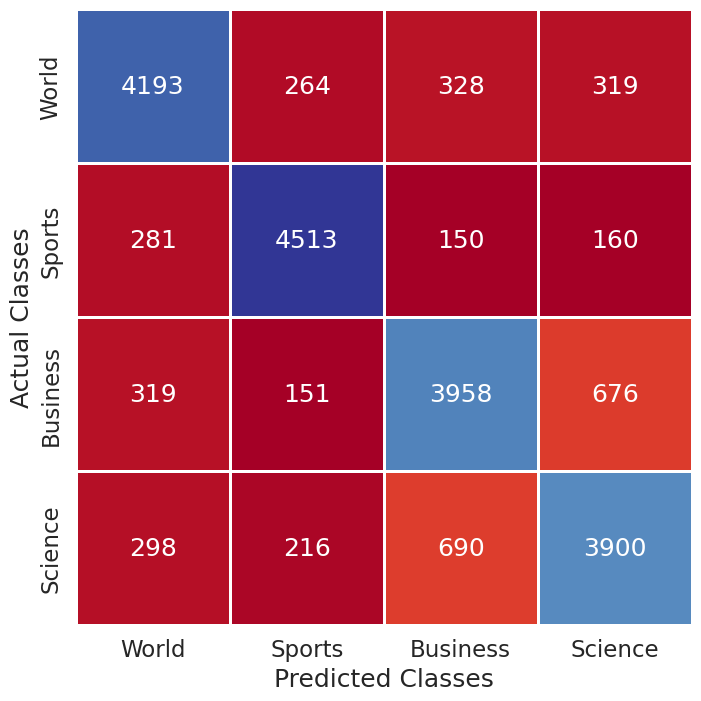

In [126]:
confusion_mat('RdYlBu')

Модель в целом хорошо различает классы новостей, показав особенно высокие результаты по "Sports".

#### Точность (Precision), полнота (Recall), F1-мера (F1-Score)

In [127]:
print('\nClassification Report\n')
print((classification_report(y_val,pred_dtg)))


Classification Report

              precision    recall  f1-score   support

           1       0.82      0.82      0.82      5104
           2       0.88      0.88      0.88      5104
           3       0.77      0.78      0.77      5104
           4       0.77      0.76      0.77      5104

    accuracy                           0.81     20416
   macro avg       0.81      0.81      0.81     20416
weighted avg       0.81      0.81      0.81     20416



#### Точность

In [128]:
c1 = round(accuracy_score(y_val,pred_dtg)*100,4)
c2 = round(100-accuracy_score(y_val,pred_dtg)*100,4)
print('Accuracy:',c1)
print('Error:',c2)

Accuracy: 81.1324
Error: 18.8676


#### Сравнение точности различных моделей для обучающей выборки (Dtrain) и валидационной выборки (Dvalidation)

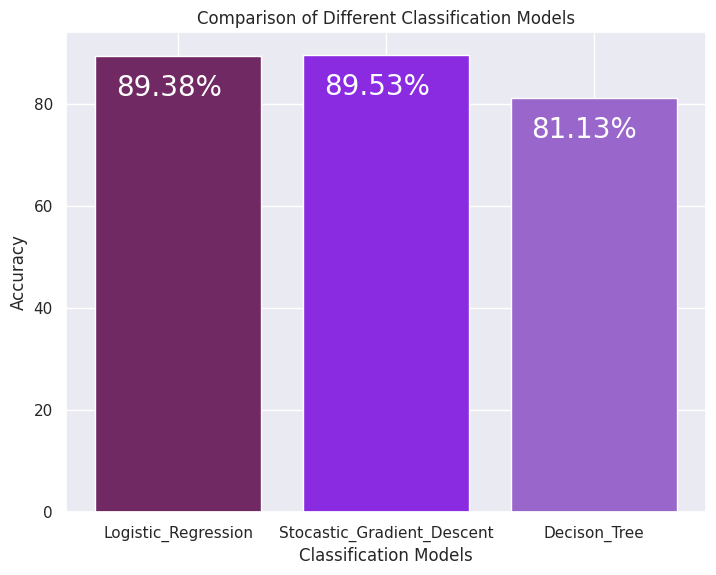

In [129]:
sns.set()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ["Logistic_Regression","Stocastic_Gradient_Descent","Decison_Tree"]
Accuracy=[a1,b1,c1]
ax.bar(Models,Accuracy,color=['#702963','#8a2be2','#9966cc']);
for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()-7.8, str(round(i.get_height(),2))+'%', fontsize=20, color='white')
plt.title('Comparison of Different Classification Models');
plt.ylabel('Accuracy');
plt.xlabel('Classification Models');

plt.show();

1. Логистическая регрессия (Logistic Regression)  
   - Показала наивысшую точность: 89.38%
   - Это говорит о том, что данная модель лучше всего справляется с задачей классификации новостей в нашем наборе данных.

2. Стохастический градиентный спуск (Stochastic Gradient Descent)  
   - Очень близкий результат: 89.53%
   - Немного уступает логистической регрессии, но разница минимальна (менее 0.3%). Это значит, что оба линейных метода (логистическая регрессия и SGD) хорошо справляются с выбранными текстовыми признаками.

3. Дерево решений (Decision Tree)  
   - Самая низкая точность: 81.13%
   - Существенно отстаёт от первых двух моделей, что говорит о том, что дерево решений хуже подходит для этой задачи классификации текста (вероятно, из-за сложности структуры признаков или переобучения на обучающей выборке).


До сих пор мы работали с данными Dtrain и Dval, а теперь нужно обработать данные Dtest (то есть ранее не встречавшиеся данные) и проверить точность на них. Проверка точности на новых данных (Dtest) для логистической регрессии.

In [130]:
pred_lr_for_unseen = lr_model.predict(X_test)

In [131]:
a11 = round(accuracy_score(y_test,pred_lr_for_unseen)*100,4)
a22 = round(100-accuracy_score(y_test,pred_lr_for_unseen)*100,4)
print('Accuracy:',a11)
print('Error:',a22)

Accuracy: 89.3495
Error: 10.6505


#### Проверка точности на новых данных (Dtest) для метода стохастического градиентного спуска (SGD).

In [132]:
pred_sgd_for_unseen = sgd_model.predict(X_test)

In [133]:
b11 = round(accuracy_score(y_test,pred_sgd_for_unseen)*100,4)
b22 = round(100-accuracy_score(y_test,pred_sgd_for_unseen)*100,4)
print('Accuracy:',b11)
print('Error:',b22)

Accuracy: 89.3417
Error: 10.6583


#### Проверка точности на новых данных (Dtest) для дерева решений.

In [134]:
pred_dtg_for_unseen = dt_model.predict(X_test)

In [135]:
c11 = round(accuracy_score(y_test,pred_dtg_for_unseen)*100,4)
c22 = round(100-accuracy_score(y_test,pred_dtg_for_unseen)*100,4)
print('Accuracy:',c11)
print('Error:',c22)

Accuracy: 80.6818
Error: 19.3182


#### Сравнение точности различных моделей на новых данных (Dtest).

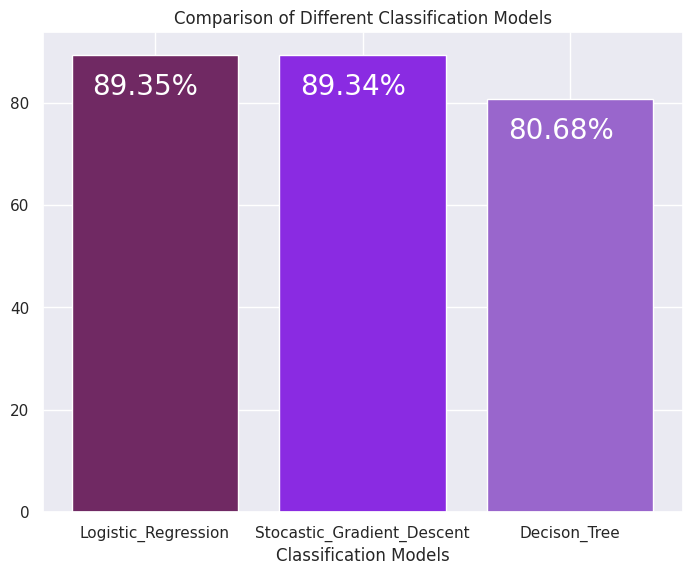

In [136]:
sns.set()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ["Logistic_Regression","Stocastic_Gradient_Descent","Decison_Tree"]
Accuracy=[a11,b11,c11]
ax.bar(Models,Accuracy,color=['#702963','#8a2be2','#9966cc']);
for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()-7.8, str(round(i.get_height(),2))+'%', fontsize=20, color='white')
plt.title('Comparison of Different Classification Models');
plt.ylabel('');
plt.xlabel('Classification Models');

plt.show();



```
# Выбран кодовый формат
```

1. Логистическая регрессия (Logistic Regression):
- Точность: 89.35%
- Показала наилучший результат из всех рассмотренных моделей.

2. Стохастический градиентный спуск (Stochastic Gradient Descent):
- Точность: 89.34%
- Результат почти такой же, как у логистической регрессии. Различие между ними минимальное (всего 0,1%).

3. Дерево решений (Decision Tree):
- Точность: 80.68%
- Значительно уступает двум первым моделям по точности, отставая примерно на 8%.

Общий вывод:
- Лучше всего для данной задачи подходят линейные модели: логистическая регрессия и стохастический градиентный спуск, которые демонстрируют практически одинаковую высокую точность.
- Дерево решений показывает заметно худший результат, и его не стоит использовать для данного набора данных и типа задачи.